# Dynamic properties of liquid Al

This example demonstrate the analysis of the dynamics of liquid aluminium via the dynamic structure factor as well as current correlation functions.
Here, we use a rather small simulation cell, a short trajectory, and few q-points in order to make the tutorial run fast.
In practice one needs to tune these parameters as well as the parameters used when calling **dynasor** for optimal results.

This example uses a trajectory that can be downloaded from zenodo via
```bash
wget https://zenodo.org/records/10013486/files/dumpT1400.NVT.atom.velocity
```
or generated from scratch by running **lammps** using the input files provided.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dynasor import compute_dynamic_structure_factors, Trajectory
from dynasor.qpoints import get_spherical_qpoints
from dynasor.post_processing import get_spherically_averaged_sample_binned

In [2]:
# set log level
from dynasor.logging_tools import set_logging_level
set_logging_level('INFO')

## Set up the trajectory for reading

**dynasor** supports multiple different trajectory formats via internal readers as well as via [mdanalysis](https://www.mdanalysis.org/) and [ase](https://wiki.fysik.dtu.dk/ase/).
Here, we use the internal lammps reader.

In [3]:
trajectory_filename = 'lammpsrun/dumpT1400.NVT.atom.velocity'
traj = Trajectory(
    trajectory_filename,
    trajectory_format='lammps_internal',
    frame_stop=5000)

INFO 2024-12-18 14:21:22: Trajectory file: lammpsrun/dumpT1400.NVT.atom.velocity
INFO 2024-12-18 14:21:22: Total number of particles: 2048
INFO 2024-12-18 14:21:22: Number of atom types: 1
INFO 2024-12-18 14:21:22: Number of atoms of type X: 2048
INFO 2024-12-18 14:21:22: Simulation cell (in Angstrom):
[[34.032  0.     0.   ]
 [ 0.    34.032  0.   ]
 [ 0.     0.    34.032]]


A short summary of the content of the `traj` object can be obtained via the `display` (in notebooks) or `print` (in notebooks or scripts) commands.

In [4]:
display(traj)

## Select **q**-points to sample

Next we specify which **q**-points should be sampled.
Here, we consider **q**-points on a three-dimensional mesh up to a maximum of |**q**| = 2 rad/Å with the maximum number of **q**-points set to 2000.

Note here that the units of q-points are technically rad/Å, however most commonly people will just denote this as 1/Å.

In [5]:
q_points = get_spherical_qpoints(traj.cell, q_max=2, max_points=2000)

INFO 2024-12-18 14:21:22: Pruning q-points from the range 0.833 < |q| < 2
INFO 2024-12-18 14:21:22: Pruned from 5377 q-points to 1986


It is useful to generate a histogram to check how many $\mathbf{q}$-points are sampled as a function of $|\mathbf{q}|$.

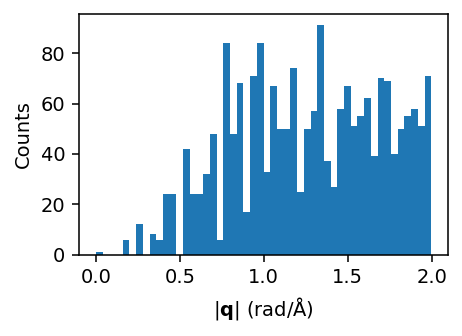

In [6]:
plt.figure(figsize=(3.4, 2.5), dpi=140)
plt.hist(np.linalg.norm(q_points, axis=1), bins=50)
plt.xlabel(r'$|\mathbf{q}|$ (rad/Å)')
plt.ylabel('Counts')
plt.tight_layout()

## Run calculation of correlation functions

We are now all set for calculating the dynamic structure factor as well as the current correlation functions (by setting `include_currents=True`).
To obtain the correct units, the spacing between the frames (`dt`) must be specified in units of femtoseconds.

The following cell should take a few minutes to run on a common work station.

In [7]:
%%time
sample_raw = compute_dynamic_structure_factors(
    traj, q_points, dt=25.0, window_size=500,
    window_step=50, calculate_currents=True)

INFO 2024-12-18 14:21:22: Spacing between samples (frame_step): 1
INFO 2024-12-18 14:21:22: Time between consecutive frames in input trajectory (dt): 25.0 fs
INFO 2024-12-18 14:21:22: Time between consecutive frames used (dt * frame_step): 25.0 fs
INFO 2024-12-18 14:21:22: Time window size (dt * frame_step * window_size): 12500.0 fs
INFO 2024-12-18 14:21:22: Angular frequency resolution: dw = 0.000251 rad/fs = 0.165 meV
INFO 2024-12-18 14:21:22: Maximum angular frequency (dw * window_size): 0.125664 rad/fs = 82.713 meV
INFO 2024-12-18 14:21:22: Nyquist angular frequency (2pi / frame_step / dt / 2): 0.125664 rad/fs = 82.713 meV
INFO 2024-12-18 14:21:22: Calculating current (velocity) correlations
INFO 2024-12-18 14:21:22: Number of q-points: 1986
INFO 2024-12-18 14:21:29: Processing window 0 to 500
INFO 2024-12-18 14:21:42: Processing window 1000 to 1500
INFO 2024-12-18 14:21:55: Processing window 2000 to 2500
INFO 2024-12-18 14:22:08: Processing window 3000 to 3500
INFO 2024-12-18 14:2

As in the case of the trajectory, we can use the `display` or `print` commands to obtain a quick summary of the [Sample object](https://dynasor.materialsmodeling.org/interface_python/sample.html) returned by the [compute_dynamic_structure_factors function](https://dynasor.materialsmodeling.org/interface_python/correlation_functions.html).

In [8]:
display(sample_raw)

DynamicSample
Atom types: ['X']
Pairs: [('X', 'X')]
Particle counts: {'X': 2048}
Simulations cell:
[[34.032  0.     0.   ]
 [ 0.    34.032  0.   ]
 [ 0.     0.    34.032]]
omega           with shape: (501,)
q_points        with shape: (1986, 3)
time            with shape: (501,)
Clqt            with shape: (1986, 501)
Clqt_X_X        with shape: (1986, 501)
Clqw            with shape: (1986, 501)
Clqw_X_X        with shape: (1986, 501)
Ctqt            with shape: (1986, 501)
Ctqt_X_X        with shape: (1986, 501)
Ctqw            with shape: (1986, 501)
Ctqw_X_X        with shape: (1986, 501)
Fqt             with shape: (1986, 501)
Fqt_coh         with shape: (1986, 501)
Fqt_coh_X_X     with shape: (1986, 501)
Sqw             with shape: (1986, 501)
Sqw_coh         with shape: (1986, 501)
Sqw_coh_X_X     with shape: (1986, 501)

## Spherical average over **q**-points

It is often of interest to take a spherical average over **q**-space, in particular in the case of liquids.
To this end, we use the [get_spherically_averaged_sample_binned function](https://dynasor.materialsmodeling.org/dev/interface_python/post_processing.html#dynasor.post_processing.get_spherically_averaged_sample_binned).

In [9]:
sample_averaged = get_spherically_averaged_sample_binned(sample_raw, num_q_bins=40)

WARNING 2024-12-18 14:22:30: No q-points for bin 1
WARNING 2024-12-18 14:22:30: No q-points for bin 2
WARNING 2024-12-18 14:22:30: No q-points for bin 3
WARNING 2024-12-18 14:22:30: No q-points for bin 1
WARNING 2024-12-18 14:22:30: No q-points for bin 2
WARNING 2024-12-18 14:22:30: No q-points for bin 3
WARNING 2024-12-18 14:22:30: No q-points for bin 1
WARNING 2024-12-18 14:22:30: No q-points for bin 2
WARNING 2024-12-18 14:22:30: No q-points for bin 3
WARNING 2024-12-18 14:22:30: No q-points for bin 1
WARNING 2024-12-18 14:22:30: No q-points for bin 2
WARNING 2024-12-18 14:22:30: No q-points for bin 3
WARNING 2024-12-18 14:22:30: No q-points for bin 1
WARNING 2024-12-18 14:22:30: No q-points for bin 2
WARNING 2024-12-18 14:22:30: No q-points for bin 3
WARNING 2024-12-18 14:22:30: No q-points for bin 1
WARNING 2024-12-18 14:22:30: No q-points for bin 2
WARNING 2024-12-18 14:22:30: No q-points for bin 3
WARNING 2024-12-18 14:22:30: No q-points for bin 1
WARNING 2024-12-18 14:22:30: No

## Visualize dynamic structure factor

We can now visualize the isotropically averaged dynamic structure factor $S(|\mathbf{q}|, \omega)$, for example, in the form of a heatmap on the momentum-frequency plane.
Note that the lower cutoff of the **q**-axis is set by the size of the supercell.

In [10]:
from dynasor.units import radians_per_fs_to_meV as conversion_factor # conversion from 1/fs to meV
sample_averaged.omega *= conversion_factor

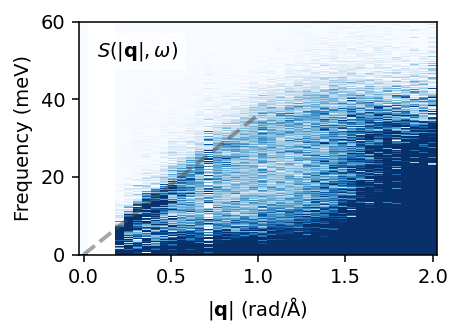

In [11]:
fig, ax = plt.subplots(figsize=(3.4, 2.5), dpi=140)

ax.pcolormesh(sample_averaged.q_norms, sample_averaged.omega,
              sample_averaged.Sqw_coh.T,
              cmap='Blues', vmin=0, vmax=4)
ax.text(0.05, 0.85, '$S(|\mathbf{q}|, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})
ax.plot([0, 1], [0, 36], alpha=0.5, ls='--', c='0.3', lw=2)

ax.set_xlabel('$|\mathbf{q}|$ (rad/Å)')
ax.set_ylabel('Frequency (meV)')
ax.set_ylim([0, 60])

fig.tight_layout()

### Visualize current correlations

Next we plot the longitudinal and transverse current correlation heatmaps.
In the longitudinal current correlation function one can observe the longitudinal branch that is also visible in the dynamic structure factor.
The transverse current correlation functions also reveals a transverse mode.

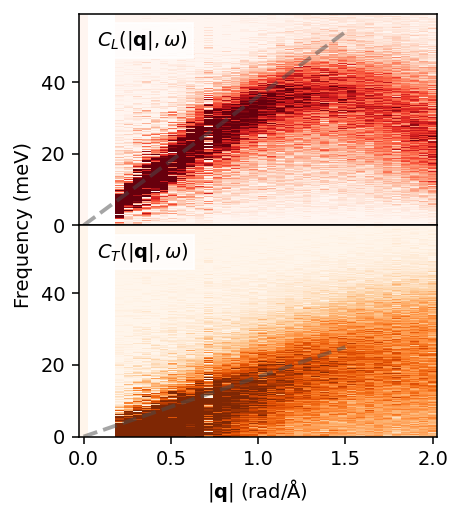

In [12]:
fig, axes = plt.subplots(figsize=(3.4, 3.8), nrows=2, dpi=140,
                         sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(sample_averaged.q_norms, sample_averaged.omega,
              sample_averaged.Clqw.T, cmap='Reds', vmin=0, vmax=4000)
ax.text(0.05, 0.85, '$C_L(|\mathbf{q}|, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})
ax.plot([0, 1.5], [0, 54], alpha=0.5, ls='--', c='0.3', lw=2)

ax = axes[1]
ax.pcolormesh(sample_averaged.q_norms, sample_averaged.omega,
              sample_averaged.Ctqw.T, cmap='Oranges', vmin=0, vmax=4000)
ax.text(0.05, 0.85, '$C_T(|\mathbf{q}|, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})
ax.plot([0, 1.5], [0, 25], alpha=0.5, ls='--', c='0.3', lw=2)

ax.set_xlabel('$|\mathbf{q}|$ (rad/Å)')
ax.set_ylabel('Frequency (meV)', y=1)
ax.set_ylim([0, 59])

fig.tight_layout()
plt.subplots_adjust(hspace=0)

## Slices in |**q**|-space

Finally, we can also inspect individually slices as demonstrated in the following cell.

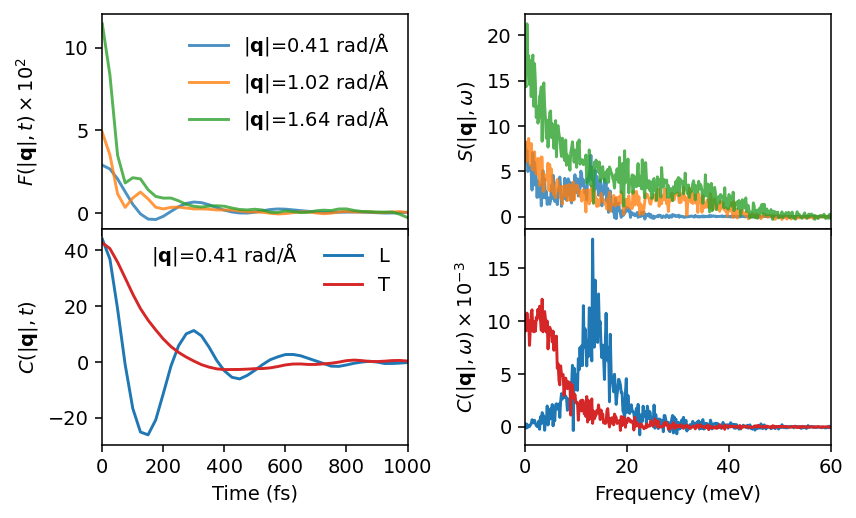

In [13]:
q_inds = [8, 20, 32]  # slices in heatmap

fig, axes = plt.subplots(figsize=(6.2, 3.8), nrows=2, ncols=2,
                         sharex='col', dpi=140)

#-----
# Intermediate scattering function and dynamic structure factor
for q_ind in q_inds:
    label = fr'$|\mathbf{{q}}|$={sample_averaged.q_norms[q_ind]:.2f} rad/Å'
    axes[0][0].plot(sample_averaged.time, sample_averaged.Fqt[q_ind, :] * 100,
                    label=label, alpha=0.8)
    axes[0][1].plot(sample_averaged.omega, sample_averaged.Sqw[q_ind, :],
                    label=label, alpha=0.8)

ax = axes[0][0]
ax.set_ylabel(r'$F(|\mathbf{q}|, t) \times 10^2$')
ax.legend(frameon=False)

ax = axes[0][1]
ax.set_ylabel('$S(|\mathbf{q}|, \omega)$')

#-----
# Current correlation functions
q_ind = q_inds[0]
axes[1][0].plot(sample_averaged.time, sample_averaged.Clqt[q_ind, :],
                label='L')
axes[1][0].plot(sample_averaged.time, sample_averaged.Ctqt[q_ind, :],
                label='T', c='C3')
axes[1][1].plot(sample_averaged.omega, sample_averaged.Clqw[q_ind, :] / 1000,
                label='L')
axes[1][1].plot(sample_averaged.omega, sample_averaged.Ctqw[q_ind, :] / 1000,
                label='T', c='C3')

ax = axes[1][0]
ax.set_xlabel('Time (fs)')
ax.set_xlim([0, 1000])
ax.set_ylabel('$C(|\mathbf{q}|, t)$')
ax.legend(frameon=False)
ax.text(0.4, 0.85, fr'$|\mathbf{{q}}|$={sample_averaged.q_norms[q_ind]:.2f} rad/Å',
        ha='center', transform=ax.transAxes)

ax = axes[1][1]
ax.set_xlabel('Frequency (meV)')
ax.set_xlim([0, 60])                 
ax.set_ylabel(r'$C(|\mathbf{q}|, \omega) \times 10^{-3}$')
                 
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.align_ylabels(axes)